Prototypes shape: (325, 4096), elements: [-1  1]
Test patterns shape: (500, 4096), elements: [-1  1]


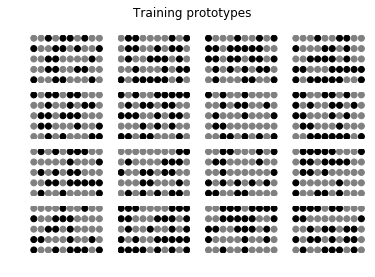

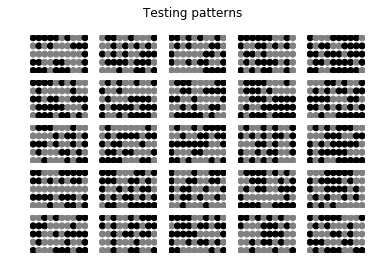

In [9]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot

np.random.seed(0)
# training prototyps
prototypes = np.random.choice([-1, +1], [325, 4096])
fig, axes = pyplot.subplots(4, 4)
fig.suptitle('Training prototypes')
for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    if i >= len(prototypes):
        continue
    colors = ['gray' if prototypes[i, j] == 1 else 'black' for j in range(prototypes.shape[1])]
    ax.scatter(np.repeat(list(range(10)), 5), np.tile(list(range(5)), 10), c=colors)

# testing patterns
vectors = np.random.choice([-1, +1], [500, 4096])
fig, axes = pyplot.subplots(5, 5)
fig.suptitle('Testing patterns')
for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    if i >= len(vectors):
        continue
    colors = ['gray' if vectors[i, j] == 1 else 'black' for j in range(vectors.shape[1])]
    ax.scatter(np.repeat(list(range(10)), 5), np.tile(list(range(5)), 10), c=colors)

print("Prototypes shape: {}, elements: {}".format(prototypes.shape, np.unique(prototypes)))
print("Test patterns shape: {}, elements: {}".format(vectors.shape, np.unique(vectors)))

In [12]:
import itertools


class HopfieldNet(object):
    def __init__(self):
        self.size = 4096
        self.units = np.random.choice([-1, +1], self.size)
        self.weights = np.zeros([self.size, self.size])
        self.threshold = 0

    def train(self, prototypes):
        n = len(prototypes)
        print("Training with {} prototypes".format(n))
        for i, j in itertools.product(list(range(self.size)), list(range(self.size))):
            if i == j:
                self.weights[i, j] = 0  # no self-connections
                continue
            self.weights[i, j] = (1 / n) * sum(
                prototypes[u, i] * prototypes[u, j]
                # (2 * prototypes[u, i] - 1) * (2 * prototypes[u, j] - 1) 
                for u in range(n))

    def set_initial(self, pattern):
        assert len(np.unique(pattern)) == 2, pattern
        for i in range(len(pattern)):
            self.units[i] = pattern[i]
            
    def update(self):
        units = list(range(len(self.units)))
        np.random.shuffle(units)
        changed = False
        for unit in units:
            unit_changed = self.update_unit(unit)
            changed = changed or unit_changed
        return changed

    def update_unit(self, unit):
        prev_state = self.units[unit]
        activation = sum(self.weights[unit, j] * self.units[j]
               for j in range(len(self.units)))
        if activation >= self.threshold:
            self.units[unit] = +1
        else:
            self.units[unit] = -1
        changed = prev_state != self.units[unit]
        return changed

In [3]:
import copy

def hamming_distance(state1, state2):
    assert len(state1) == len(state2)
    return sum(state1[i] != state2[i] for i in range(len(state1)))


prototype_nums = [1, 4, 7, 14]
num_unique_states, prototype_distances, block_updates = {}, {}, {}
for num_prototypes in prototype_nums:
    # train network
    net = HopfieldNet()
    train_prototypes = prototypes[:num_prototypes, :]
    net.train(train_prototypes)
    # test network and count the number of updates required to converge
    updates, final_states = [], []
    for pattern in range(vectors.shape[0]):
        net.set_initial(vectors[pattern, :])
        for block in itertools.count():
            changed = net.update()
            if not changed:
                break  # done, converged
        final_states.append(copy.deepcopy(net.units))
        updates.append(block)
    block_updates[num_prototypes] = updates

    # compare the final states to themselves and to the prototypes
    num_unique = 0
    unique_states = []
    prototype_distance = []
    for state in final_states:
        # figure out unique states
        overlap = False
        for distinct_state in unique_states:
            distance = hamming_distance(state, distinct_state)
            if distance == 0:
                overlap = True
                break
        if not overlap:
            num_unique += 1
            unique_states.append(state)
        # compare to prototypes
        min_distance = 999
        for prototype in train_prototypes:
            distance = hamming_distance(state, prototype)
            if distance < min_distance:  # closest prototype
                min_distance = distance
        prototype_distance.append(min_distance)
    num_unique_states[num_prototypes] = num_unique
    prototype_distances[num_prototypes] = prototype_distance
print("Updates", block_updates)
print("Unique states", num_unique_states)
print("Prototype distances", prototype_distances)

Training with 1 prototypes
Training with 4 prototypes
Training with 7 prototypes
Training with 14 prototypes
Updates {1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 4: [1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 3, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 2, 1, 1], 7: [2, 2, 2, 3, 2, 1, 2, 2, 4, 2, 2, 2, 4, 1, 5, 2, 3, 3, 4, 2, 2, 1, 4, 2, 2], 14: [5, 7, 3, 6, 2, 1, 3, 3, 5, 7, 3, 4, 3, 3, 3, 3, 7, 6, 3, 7, 4, 2, 2, 3, 2]}
Unique states {1: 2, 4: 12, 7: 18, 14: 17}
Prototype distances {1: [50, 50, 0, 0, 50, 50, 0, 50, 0, 0, 0, 0, 0, 0, 50, 50, 0, 50, 50, 50, 50, 0, 50, 0, 0], 4: [24, 23, 0, 24, 24, 23, 24, 24, 0, 0, 0, 0, 0, 0, 24, 23, 0, 13, 24, 23, 0, 0, 12, 12, 10], 7: [23, 20, 23, 25, 24, 23, 15, 0, 0, 12, 22, 12, 9, 0, 18, 6, 0, 17, 18, 0, 25, 0, 18, 9, 0], 14: [2, 13, 7, 8, 16, 11, 7, 7, 10, 17, 10, 10, 5, 13, 16, 15, 10, 13, 15, 10, 5, 5, 11, 1, 10]}


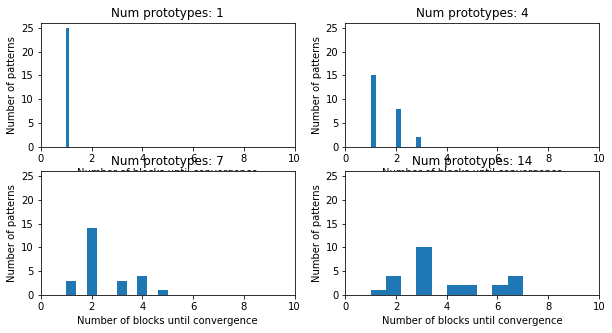

In [4]:
% matplotlib inline
from matplotlib import pyplot

fig, axes = pyplot.subplots(2, 2, figsize=(10, 5))
for ax, (num_prototypes, updates) in zip(axes.flatten(), block_updates.items()):
    ax.set_title('Num prototypes: {}'.format(num_prototypes))
    ax.hist(updates)
    ax.set_xlabel("Number of blocks until convergence")
    ax.set_ylabel("Number of patterns")
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 26])

In [10]:
train_prototypes = prototypes
train_prototypes.shape

(325, 4096)

In [ ]:
num_unique_states, prototype_distances, block_updates = {}, {}, {}
# train network
net = HopfieldNet()
train_prototypes = prototypes
net.train(train_prototypes)
# test network and count the number of updates required to converge
updates, final_states = [], []
for pattern in range(vectors.shape[0]):
    net.set_initial(vectors[pattern, :])
    for block in itertools.count():
        changed = net.update()
        if not changed:
            break  # done, converged
    final_states.append(copy.deepcopy(net.units))
    updates.append(block)
block_updates[num_prototypes] = updates

# compare the final states to themselves and to the prototypes
num_unique = 0
unique_states = []
prototype_distance = []
for state in final_states:
    # figure out unique states
    overlap = False
    for distinct_state in unique_states:
        distance = hamming_distance(state, distinct_state)
        if distance == 0:
            overlap = True
            break
    if not overlap:
        num_unique += 1
        unique_states.append(state)
    # compare to prototypes
    min_distance = 999
    for prototype in train_prototypes:
        distance = hamming_distance(state, prototype)
        if distance < min_distance:  # closest prototype
            min_distance = distance
    prototype_distance.append(min_distance)
num_unique_states[num_prototypes] = num_unique
prototype_distances[num_prototypes] = prototype_distance
print("Updates", block_updates)
print("Unique states", num_unique_states)
print("Prototype distances", prototype_distances)

Training with 325 prototypes
